## This notebook is used for the qPCR data analyses

In [1]:
library(ggplot2)
library(dplyr) 
library(wesanderson)
library(phyloseq)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [195]:
df = read.csv("../../data/qPCR/WB2015_qPCR_table_pub.csv")

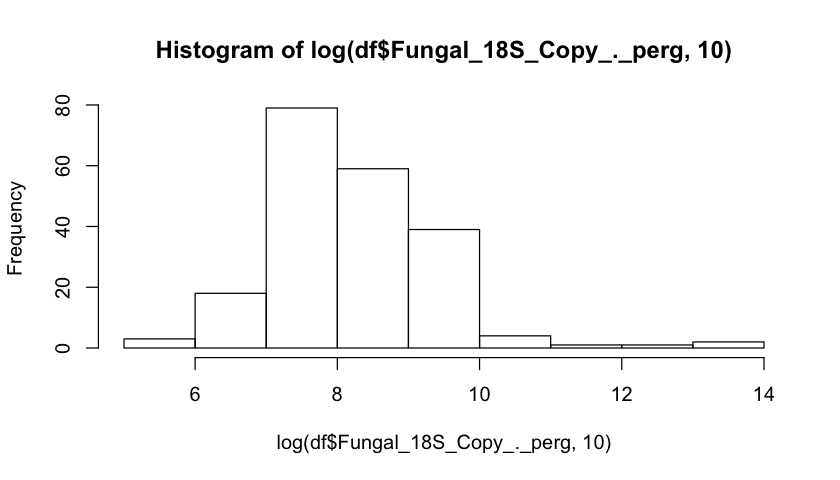

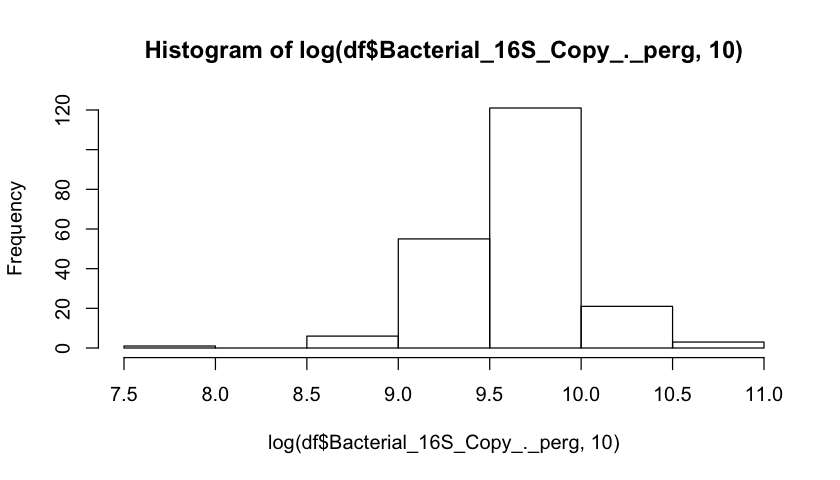

In [196]:
hist(log(df$Fungal_18S_Copy_._perg,10))
hist(log(df$Bacterial_16S_Copy_._perg,10))

In [197]:
# A couple of samples had very high predicted fungal copy numbers 
# Or very low bacterial copy numbers, often out of contrast with their paired extractions
# Omitting

df = df[(df$Fungal_18S_Copy_._perg<1e12 & df$Bacterial_16S_Copy_._perg>1e8) & !is.na(df$Fungal_18S_Copy_._perg) & !is.na(df$Bacterial_16S_Copy_._perg),]

In [198]:
# Formatting data
df$pH = as.numeric(paste(df$pH))
df$Burn_Severity_Index = as.numeric(paste(df$Burn_Severity_Index))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [199]:
df = df %>%
    group_by(Sample_ID,Org_or_Min,Veg_Comm,Land_Class,pH,Moisture,Moisture_Regime,
             Sand_pct,Clay_pct,Silt_pct,Interval,Pct_Exposed_Mineral,RBR,Understory_CBI,
             CBI,Burned_Unburned,CFSI,Burn_Severity_Index,Mean_Duff_Depth_cm,O_Depth_cm,
             Severity_Class,Total_N_pct,TC_pct)%>%
    summarize(mean18S = mean(Fungal_18S_Copy_._perg),mean16S = mean(Bacterial_16S_Copy_._perg),
             BF = log(mean16S/mean18S,10))

In [200]:
# Calculating derived quantities
d = df %>%
    group_by(Sample_ID,Org_or_Min,Veg_Comm,Land_Class,pH,Moisture,Moisture_Regime,Sand_pct,Clay_pct,Silt_pct,Interval,Pct_Exposed_Mineral,RBR,Understory_CBI,CBI,Burned_Unburned,CFSI,Burn_Severity_Index,Mean_Duff_Depth_cm,O_Depth_cm,Severity_Class,Total_N_pct,TC_pct,mean16S,mean18S)%>%
    summarize(Fungal18S = mean(mean18S),Bact16S = mean(mean16S))
d = d[2:dim(d)[1],]
d$BF = d$Bact16S/d$Fungal18S
d$Severity_Class = ordered(d$Severity_Class,levels=c("Unburned","Low","Moderate","High"))


Call:
lm(formula = log(F.u$BF, 10) ~ F.u$pH)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6790 -0.5786 -0.1983  0.6970  2.0304 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -1.0164     0.6729  -1.510  0.13531   
F.u$pH        0.3546     0.1048   3.382  0.00117 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8093 on 72 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.1371,	Adjusted R-squared:  0.1251 
F-statistic: 11.44 on 1 and 72 DF,  p-value: 0.001166



Call:
lm(formula = log(F.w$BF, 10) ~ F.w$pH)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8732 -0.1506  0.1941  0.4932  1.3280 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.2868     1.3442   0.213    0.833
F.w$pH        0.1492     0.2135   0.699    0.493

Residual standard error: 1.128 on 18 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.02644,	Adjusted R-squared:  -0.02765 
F-statistic: 0.4888 on 1 and 18 DF,  p-value: 0.4934


Warning message:
“Removed 7 rows containing missing values (geom_point).”

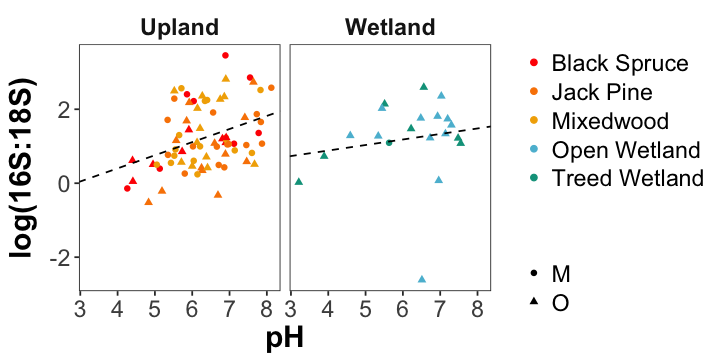

In [201]:
# Testing relationship of 16S:18S with pH

options(repr.plot.width=6, repr.plot.height=3)

F.u = d%>%
    filter(Land_Class=="Upland")
a.u = lm(log(F.u$BF,10)~F.u$pH)
summary(a.u)

F.w = d%>%
    filter(Land_Class=="Wetland")
a.w = lm(log(F.w$BF,10)~F.w$pH)
summary(a.w)

p = ggplot(d,aes(x=pH,y=log(BF,10), color=Veg_Comm, shape=Org_or_Min))
p = p + geom_point() + facet_grid(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("log(16S:18S)")

linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(a.u[[1]][2] ,a.w[[1]][2]), intercept=c(a.u[[1]][1] ,a.w[[1]][1]))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)

p


Call:
lm(formula = log(F.u$BF, 10) ~ F.u$Burn_Severity_Index)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7284 -0.6400 -0.1521  0.6247  2.1806 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.58195    0.25866   6.116    4e-08 ***
F.u$Burn_Severity_Index -0.09891    0.07472  -1.324     0.19    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8562 on 75 degrees of freedom
Multiple R-squared:  0.02283,	Adjusted R-squared:  0.009798 
F-statistic: 1.752 on 1 and 75 DF,  p-value: 0.1896



Call:
lm(formula = log(F.w$BF, 10) ~ F.w$Burn_Severity_Index)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7881 -0.3137  0.0491  0.5845  1.4698 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)
(Intercept)              1.07928    0.67828   1.591    0.126
F.w$Burn_Severity_Index  0.09405    0.28363   0.332    0.743

Residual standard error: 1.127 on 22 degrees of freedom
Multiple R-squared:  0.004973,	Adjusted R-squared:  -0.04026 
F-statistic:  0.11 on 1 and 22 DF,  p-value: 0.7433


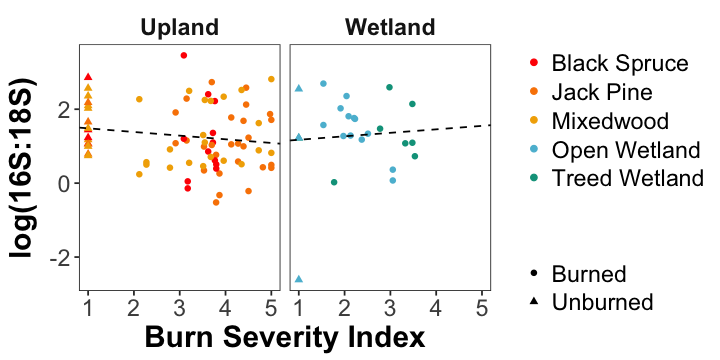

In [202]:
# Testing relationship of 16S:18S with burn severity index

options(repr.plot.width=6, repr.plot.height=3)

F.u = d%>%
    filter(Land_Class=="Upland")
b.u = lm(log(F.u$BF,10)~F.u$Burn_Severity_Index)
summary(b.u)

F.w = d%>%
    filter(Land_Class=="Wetland")
b.w = lm(log(F.w$BF,10)~F.w$Burn_Severity_Index)
summary(b.w)

p = ggplot(d,aes(x=Burn_Severity_Index,y=log(BF,10), color=Veg_Comm, shape=Burned_Unburned))
p = p + geom_point() + facet_wrap(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("log(16S:18S)") + xlab("Burn Severity Index")

#linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(b.u[[1]][2] ,b.w[[1]][2]), intercept=c(b.u[[1]][1] ,b.w[[1]][1]))
linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(b.u[[1]][2] ,b.w[[1]][2]), intercept=c(b.u[[1]][1] ,b.w[[1]][1]))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)

p


Call:
lm(formula = log(F.u$Bact16S, 10) ~ F.u$Burn_Severity_Index)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82688 -0.15909  0.06002  0.14884  0.91980 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              9.80164    0.09065 108.132   <2e-16 ***
F.u$Burn_Severity_Index -0.02820    0.02619  -1.077    0.285    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3001 on 75 degrees of freedom
Multiple R-squared:  0.01522,	Adjusted R-squared:  0.002092 
F-statistic: 1.159 on 1 and 75 DF,  p-value: 0.2851



Call:
lm(formula = log(F.w$Bact16S, 10) ~ F.w$Burn_Severity_Index)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46603 -0.14351  0.00466  0.14826  0.41757 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              9.75979    0.15989  61.042   <2e-16 ***
F.w$Burn_Severity_Index -0.06494    0.06686  -0.971    0.342    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2656 on 22 degrees of freedom
Multiple R-squared:  0.04112,	Adjusted R-squared:  -0.002468 
F-statistic: 0.9434 on 1 and 22 DF,  p-value: 0.342


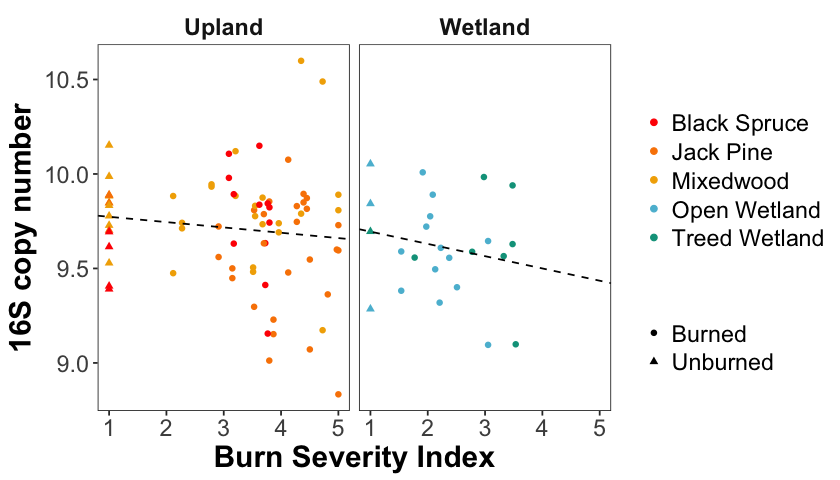

In [203]:
options(repr.plot.width=7, repr.plot.height=4)

F.u = d%>%
    filter(Land_Class=="Upland")
b.u = lm(log(F.u$Bact16S,10)~F.u$Burn_Severity_Index)
summary(b.u)

F.w = d%>%
    filter(Land_Class=="Wetland")
b.w = lm(log(F.w$Bact16S,10)~F.w$Burn_Severity_Index)
summary(b.w)

p = ggplot(d,aes(x=Burn_Severity_Index,y=log(Bact16S,10), color=Veg_Comm, shape=Burned_Unburned))
p = p + geom_point() + facet_wrap(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("16S copy number") + xlab("Burn Severity Index")

linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(b.u[[1]][2] ,b.w[[1]][2]), intercept=c(b.u[[1]][1] ,b.w[[1]][1]))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)

#p = p + facet_wrap(~Veg_Comm)

p


Call:
lm(formula = log(F.u$Fungal18S, 10) ~ F.u$Burn_Severity_Index)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.91575 -0.65896  0.06361  0.61512  1.55977 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              8.21969    0.24350  33.756   <2e-16 ***
F.u$Burn_Severity_Index  0.07071    0.07035   1.005    0.318    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8061 on 75 degrees of freedom
Multiple R-squared:  0.01329,	Adjusted R-squared:  0.0001372 
F-statistic:  1.01 on 1 and 75 DF,  p-value: 0.318



Call:
lm(formula = log(F.w$Fungal18S, 10) ~ F.w$Burn_Severity_Index)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5398 -0.6304 -0.1291  0.2732  3.3788 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)               8.6805     0.6083  14.271 1.33e-12 ***
F.w$Burn_Severity_Index  -0.1590     0.2543  -0.625    0.538    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.01 on 22 degrees of freedom
Multiple R-squared:  0.01745,	Adjusted R-squared:  -0.02721 
F-statistic: 0.3907 on 1 and 22 DF,  p-value: 0.5383


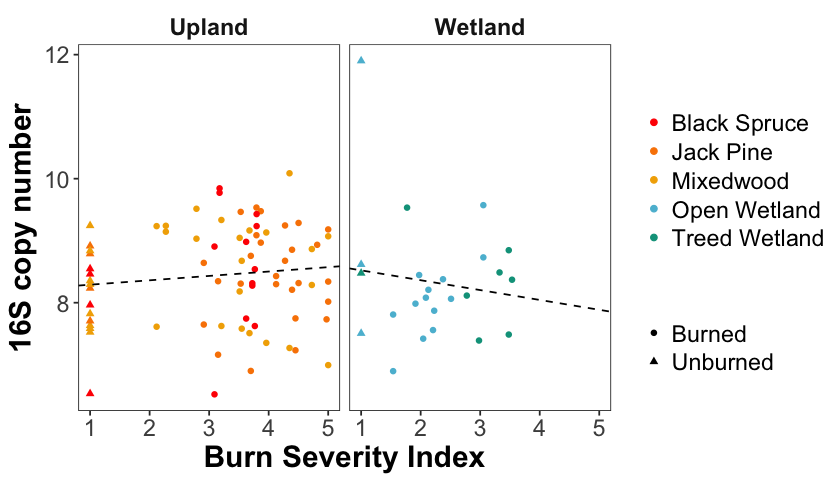

In [192]:
options(repr.plot.width=7, repr.plot.height=4)

F.u = d%>%
    filter(Land_Class=="Upland")
b.u = lm(log(F.u$Fungal18S,10)~F.u$Burn_Severity_Index)
summary(b.u)

F.w = d%>%
    filter(Land_Class=="Wetland")
b.w = lm(log(F.w$Fungal18S,10)~F.w$Burn_Severity_Index)
summary(b.w)

p = ggplot(d,aes(x=Burn_Severity_Index,y=log(Fungal18S,10), color=Veg_Comm, shape=Burned_Unburned))
p = p + geom_point() + facet_wrap(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("16S copy number") + xlab("Burn Severity Index")

linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(b.u[[1]][2] ,b.w[[1]][2]), intercept=c(b.u[[1]][1] ,b.w[[1]][1]))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)

#p = p + facet_wrap(~Veg_Comm)

p